## Homework 3 done by Ivan Akinfiev 

### Problem 1

In [292]:
import numpy as np 
import pandas as pd 
from scipy.io import arff
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [293]:
data = arff.loadarff('data.arff')
df = pd.DataFrame(data[0])
df['class'] = df['class'].replace({b'tested_positive': 1, b'tested_negative': -1})
df.head()

,preg,plas,pres,skin,insu,mass,pedi,age,class
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0,1
1,1.0,85.0,66.0,29.0,0.0,26.6,0.351,31.0,-1
2,8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0,1
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,-1
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,1


Composing 

$$ \mathcal{B} = \left \{ \sigma \cdot (2\mathbb{I}(x_i \leq t) - 1) : \sigma \in \{\pm 1\}, i \in \{1, \ldots, d\}, t \in \mathbb{R} \right \} $$ 

In [294]:
train, test  = train_test_split(df, train_size=100, shuffle=True)
test.shape

(668, 9)

##### This is my first attempt to implement in $ O(dm^2) $. It works pretty slowly. Completely impractical at large $t$ 

In [295]:
def ERM_DS_naive(train: pd.DataFrame, D: np.ndarray):
    theta_star = 0
    F_star = np.inf
    columns = train.columns 
    j_star = -1
    for j in range(len(columns) - 1):  
        parsed_j = train[columns[j]].values
        parsed_j = np.append(parsed_j, parsed_j[-1] + 1)
        theta = parsed_j[0] - 1
        for i in range(train.shape[0]):
            F = 0
            theta = (parsed_j[i] + parsed_j[i+1]) / 2
            for k in range(train.shape[0]):
                if theta > parsed_j[k] and train.iloc[k, -1] == 1:
                    F += D[k]
                if theta < parsed_j[k] and train.iloc[k, -1] == -1:
                    F += D[k]
            if F < F_star:
                F_star = F
                j_star = j
                theta_star = theta
                    
    return j_star, theta_star     
    

This is algorithm from Shai, UML. It works in $O(dm)$ 

In [296]:
def ERM_DS(train: pd.DataFrame, D: list):
    theta_star = 0
    F_star = np.inf
    columns = train.columns[:-1]  
    j_star = -1
    m = train.shape[0]
    D = np.array(D) 

    for j in range(len(columns)):
        sorted_idx = train[columns[j]].argsort()
        sorted_x = train.iloc[sorted_idx, j].values
        sorted_y = train.iloc[sorted_idx, -1].values
        sorted_D = D[sorted_idx]

        F = np.sum(sorted_D[sorted_y == 1])
        if F < F_star:
            F_star = F
            j_star = j
            theta_star = sorted_x[0] - 1 
        for i in range(m - 1):
            F += sorted_D[i] * (1 if sorted_y[i] == -1 else -1)
            if F < F_star and sorted_x[i] != sorted_x[i + 1]:
                F_star = F
                j_star = j
                theta_star = (sorted_x[i] + sorted_x[i + 1]) / 2
    return j_star, theta_star   

A couple of helper functions.

In [297]:
def indicator(y_true, y_pred):
    return np.where(y_true != y_pred, 1, 0)
    
def h(x, theta):
    return np.where(x <= theta, 1, -1)
    

Algo itself. 

In [316]:
def ADA_BOOST(train: pd.DataFrame, T: int):
    D = np.array([1 / train.shape[0]] * train.shape[0])
    weights = []
    h_s = []
    for t in range(T):
        j_t, theta_t = ERM_DS(train, D)
        y_true = train.iloc[:, -1].values
        y_pred = h(train.iloc[:, j_t].values, theta_t)
        epsilon_t = np.sum(D * indicator(y_true, y_pred))
        # ADD SMALL NUMBER TO AVOID DIVISION BY ZERO. 
        epsilon_t = max(epsilon_t, 1e-10)
        w_t = 0.5 * np.log((1 - epsilon_t) / epsilon_t)
        
        D *= np.exp(-w_t * y_true * y_pred)
        D /= D.sum()
        
        weights.append(w_t)
        h_s.append((j_t, theta_t))
    
    return weights, h_s
    
        
        
        
weights, h_s = ADA_BOOST(train, 3000)

In [304]:
def ada_boost_eval(train: pd.DataFrame, test:pd.DataFrame, weights, h_s):
    X_train = train.iloc[:, :-1].values 
    X_test = test.iloc[:,:-1].values
    y_train = train.iloc[:, -1].values
    y_test = test.iloc[:,-1].values
    predictions_test = np.zeros(shape=(len(weights,)))
    predictions_train = np.zeros(shape=(len(weights,)))
    exp_loss_of_t = np.zeros(shape=(len(weights,)))
    for t in range(len(h_s)):
        prediction_number_train = np.zeros(X_train.shape[0])
        prediction_number_test = np.zeros(X_test.shape[0])
        for s, (j_s, theta_s) in enumerate(h_s[:t]):
            d = h(X_train[:, j_s],theta_s)
            prediction_number_train += weights[s] * h(X_train[:, j_s], theta_s)
            prediction_number_test += weights[s] * h(X_test[:, j_s], theta_s)
        predictions_train_h = np.sign(prediction_number_train)
        predictions_test_h = np.sign(prediction_number_test)
        accuracy_train = np.mean(y_train == predictions_train_h)
        accuracy_test = np.mean(y_test == predictions_test_h)
        predictions_train[t] = accuracy_train
        predictions_test[t] = accuracy_test
        exp_loss = np.sum(np.exp(-(prediction_number_train*y_train)))
        exp_loss_of_t[t] = exp_loss
        
        
    return predictions_train, predictions_test, exp_loss_of_t
    
predictions_train, predictions_test, exp_loss_of_t = ada_boost_eval(train,test, weights, h_s)


In [305]:
predictions_train

array([0.  , 0.6 , 0.6 , ..., 0.62, 0.62, 0.62])

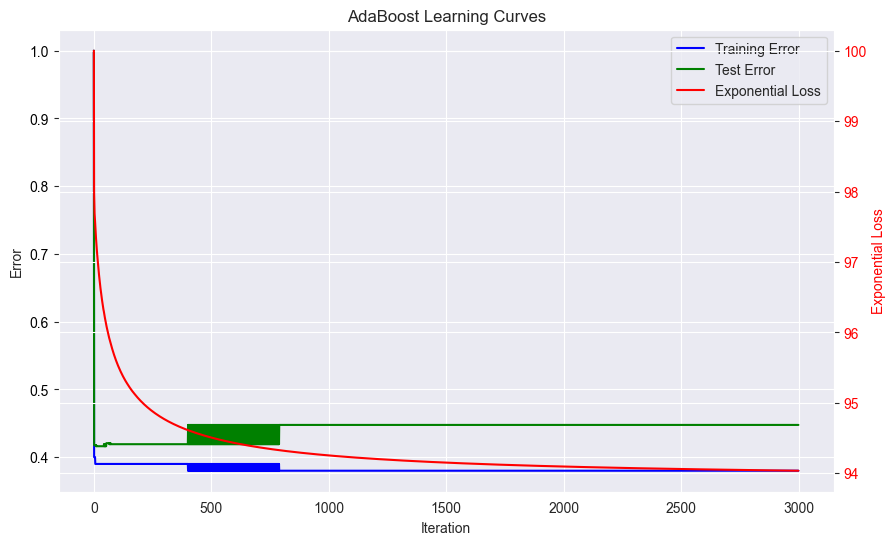

In [315]:
t = np.arange(len(weights))
fig, ax1 = plt.subplots(figsize=(10, 6))
train_error_line, = ax1.plot(t, 1 - predictions_train, color='blue', label='Training Error')
test_error_line, = ax1.plot(t, 1 - predictions_test, color='green', label='Test Error')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Error')
ax1.tick_params(axis='y', labelcolor='black')
ax2 = ax1.twinx()
exp_loss_line, = ax2.plot(t, exp_loss_of_t, color='red', label='Exponential Loss')
ax2.set_ylabel('Exponential Loss', color='red')
ax2.tick_params(axis='y', labelcolor='red')
plt.title('AdaBoost Learning Curves')
lines = [train_error_line, test_error_line, exp_loss_line]
ax1.legend(lines, [line.get_label() for line in lines])
plt.show()

We see classical learning curves, at some point test error starts increasing, while training error goes down as expected, so the exponential loss. However, interesting to note, that at 400 < t < 500 iterations, the AdaBoost stopped learning. We can see it from the weights that almost repeating themselves at the end. 

In [317]:
weights[-10:]

[0.0009346360304307173,
 0.0009345444813734688,
 0.0009336719231768263,
 0.0009340853823730036,
 0.000933213680861494,
 0.0009337594283504078,
 0.0009328883348191226,
 0.0009327971300232735,
 0.0009319278301658351,
 0.0009323397540796247]

## b) 

In [322]:
def norm_margin(train, weights, h_s, t):
    X_train = train.iloc[:, :-1].values
    y_train = train.iloc[:, -1].values
    f_t = np.zeros(X_train.shape[0])
    alpha = np.sum(weights[:t])
    for s, (j_s, theta_s) in enumerate(h_s[:t]):
        f_t += weights[s] * h(X_train[:, j_s], theta_s)
    n_f_t = f_t / alpha
    n_margin = y_train * n_f_t
    return n_margin

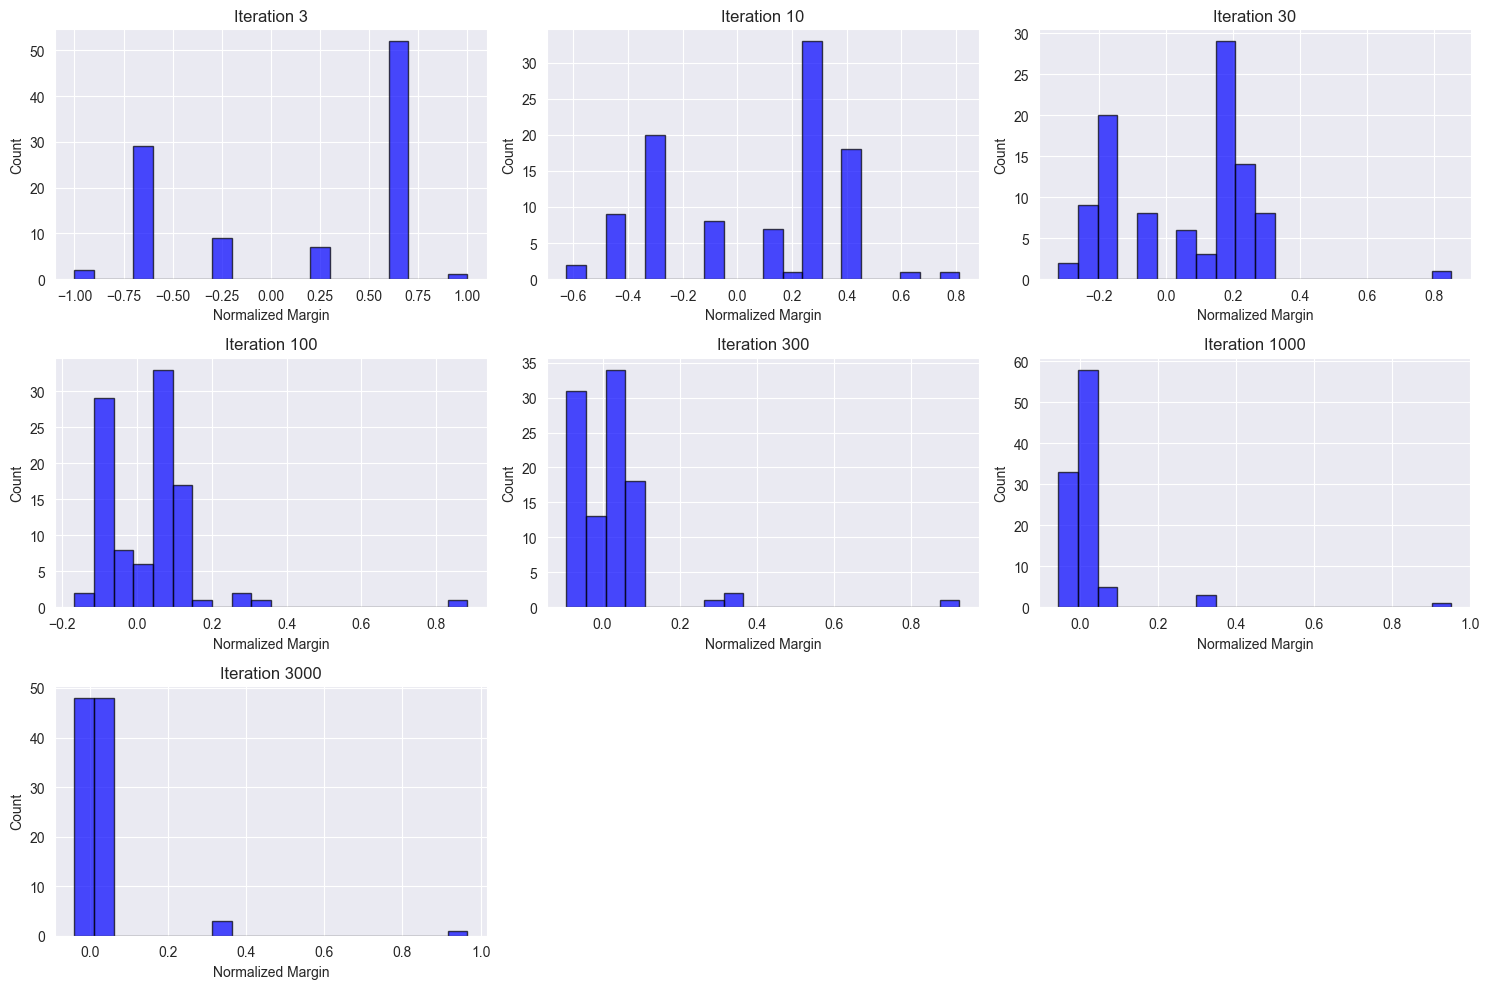

In [321]:
iters = [3, 10, 30, 100, 300, 1000, 3000]
plt.figure(figsize=(15, 10))

for i, t in enumerate(iters, 1):
    normalized_margin = norm_margin(train, weights, h_s, t)
    plt.subplot(3, 3, i)
    plt.hist(normalized_margin, bins=20, alpha=0.7, color='blue', edgecolor='black')
    plt.title(f'Iteration {t}')
    plt.xlabel('Normalized Margin')
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

Indeed, we see a trend that Normalized Margin tends to get skewed to 0 as we increase t. 

### Problem 2 


$$ \sum_{t+1}^{m}D_{t+1}I(h_t(x_i) \neq y_i) = \frac{1}{2} $$ 

Proof:



$$ \sum_{t+1}^{m}D_{t+1}I(h_t(x_i) \neq y_i) = \frac{\sum_{i=1}{m}D_te^{-wh_t(x_i)y_i}\{h_t(x_i) \neq y_i\}}{\sum_{i=1}^{m}D_te^{-wh_t(x_i)y_i}} $$ 

Let's divide it using the definition of indicator function: 

$$ \frac{\sum_{K}^{}D_te^{-wh_t(x_i)y_i}\cdot 1}{\sum_{i=1}^{m}D_te^{-wh_t(x_i)y_i}} + \frac{\sum_{E}D_te^{-wh_t(x_i)y_i}\cdot 0}{\sum_{i=1}^{m}D_te^{-wh_t(x_i)y_i}} = \frac{\sum_{K}D_te^{-wh_t(x_i)y_i}}{\sum_{i=1}^{m}D_te^{-wh_t(x_i)y_i}}$$   

Where $ w = \frac{1}{2}ln(\frac{1-\epsilon}{\epsilon})$ Here, since $ h_t(x_i) \neq y_i $ 

$$ \frac{\sum_{K}D_te^{-wh_t(x_i)y_i}}{\sum_{i=1}^{m}D_te^{-wh_t(x_i)y_i}} = \frac{\sum_{K}D_te^{-w}}{\sum_{i=1}^{m}D_te^{-wh_t(x_i)y_i}}= $$
$$ \frac{\sum_{K}D_te^{-w}}{\sum_{i=1}^{m}D_te^{-wh_t(x_i)y_i}}= \frac{\sum_{K}D_t}{\sum_{i=1}^{m}\frac{D_te^{-wh_t(x_i)y_i}}{e^{w}}= $$
Using the same trick, 
$$  \frac{\sum_{K}D_t}{\sum_{i=1}^{m}\frac{D_te^{-wh_t(x_i)y_i}}{e^{w}}}=\frac{\sum_{K}D_t}{\sum_{K}D_t+e^{-2w}\sum_{E}D_t} = $$ 
Reversing the log function: $ e^{2w} = \frac{1-ϵ}{ϵ} $ So, 

$$\frac{\sum_{K}D_t}{\sum_{K}D_t+\sum_{E}D_t} = w ⇒ \sum_{E}D_t = \frac{\sum_{K}D_t}{w} - \sum_{K}D_t$$

Now, replacing $\sum_{E}D_t$, we have 

$$ \frac{\sum_{K}D_t}{\sum_{K}D_t+e^{-2w}\sum_{E}D_t} = \frac{\sum_{K}D_t}{\sum_{K}D_t+e^{-2w}\frac{\sum_{K}D_t}{w} - \sum_{K}D_t} = $$
$$ \frac{\sum_{K}D_t}{\sum_{K}D_t+\frac{w}{1-w}\frac{\sum_{K}D_t}{w} - \sum_{K}D_t} $$
$$  \frac{\sum_{K}D_t}{\sum_{K}D_t + \frac{\sum_{K}D_t}{1-w}-\frac{w}{1-w}\sum_{K}D_t}. $$
$$ = \frac{1}{1+\frac{1}{1-w}-\frac{w}{1-w}} = 1/1+1 = \frac{1}{2}$$

### Problem 3


To solve this problem we need to collect multiple fact. Since, we are dealing with regression problem, is it quite hard to use VC-dimension. There are attempts to discreditize a response space or find a class of indicator functions that can be formed by thresholding that class of real-valued functions. However, there is far more useful tool - Rademacher Complexity. First of all, let's build our skeleton.

From "UML" by Shai et.al, p. 378, the theorem is provided: 

$$ L_{\mathcal{D}}(ERM_{\mathcal{H}}(S)) - min_{h \in \mathcal{H}}L_{\mathcal{D}} \leq 2R(\mathcal{l} \circ \mathcal{H} \circ S) + 5 c \cdot \sqrt{\frac{2ln(8/δ)}{m}}  $$

for any $ h \in \mathcal{H} $. We need to figure out $c$ and $R$. First of all, let's use Contraction Lemma, which states that, 

$$ \mathbb{E}\left [ sup_{h \in \mathcal{H}} \frac{1}{m} \sum_{i=1}^{m}\sigma_i\phi(h(x_i)) \right ] \leq L \cdot \mathbb{E}\left [ sup_{h \in \mathcal{H}} \frac{1}{m} \sum_{i=1}^{m}\sigma_ih(x_i) \right ] $$ 

Notice that square loss is a Lipschitz function $\mathcal{l} = (\hat{y} - y)^2 $, which is bounded by $[-Y,Y]$. Therefore, we automatically get $ c = 2Y $. 
Therefore, the bound becomes

$$  L_{\mathcal{D}}(ERM_{\mathcal{H}}(S)) - min_{h \in \mathcal{H}}L_{\mathcal{D}} \leq 2R(\mathcal{l} \circ \mathcal{H} \circ S) + 10Y \cdot \sqrt{\frac{2ln(8/δ)}{m}}$$ 

Now, let's figure out the Rademacher complexity. By definition, 

$$ R(\mathcal{l} \circ \mathcal{H} \circ S) = \mathbb{E}_{\sigma}\left [\text{sup}\frac{1}{m}\sum_{i=1}^{m}\sigma_ih(x_i) \right ]$$

Given by the problem, $ h(x) = \left <w,x \right  > $, s.t  $ ||x||_{\infty} \leq R $ and $ ||w||_{1} \leq B $. Let's plug in directly 
$$ \mathbb{E}_{\sigma}\left [\text{sup}\frac{1}{m}\sum_{i=1}^{m}\sigma_ih(x_i) \right ] =  \mathbb{E}_{\sigma}\left [\text{sup}\frac{1}{m}\sum_{i=1}^{m}\sigma_i\left <x_i,w \right > \right ] $$

By the linearity of expectation, 

$$  \mathbb{E}_{\sigma}\left [\text{sup}\frac{1}{m}\sum_{i=1}^{m}\sigma_i\left <x_i,w \right > \right ] = \text{sup} \; \frac{1}{m}\mathbb{E}_{\sigma}\left [\sum_{i=1}^{m}\sigma_i\left <x_i,w \right > \right ]   $$ 

Here, the Holder inequality comes perfectly with satisfied property that $ 1/p + 1/q = 1 $, since, $1/\infty + 1/1 = 1 $. Both norms are already bounded, so 

$$ \text{sup} \; \frac{1}{m}\mathbb{E}_{\sigma}\left [\sum_{i=1}^{m}\sigma_i\left <x_i,w \right > \right ] \leq  \text{sup} \; \frac{1}{m}\mathbb{E}_{\sigma}\left [\sum_{i=1}^{m}\sigma_i\ B \cdot R \right ] = $$
$$ \text{sup} \; \frac{BR}{m}\mathbb{E}_{\sigma}\left [\sum_{i=1}^{m}\sigma_i\ \right ] $$

The part of this step is taken from Shai p.382 lemma 26.10. Here is a conceptual trick, since the original expected value of Rademacher RV is zero. However, we are interested in the minimum deviation, so we take the absolute value, 


$$ \mathbb{E} \left | \sum_{i=1}^{m}\sigma_i \right | $$ 

which is equals $\sqrt{m}$ Combining everything, we get the resulting bound inequality:  

$$L_{\mathcal{D}}(ERM_{\mathcal{H}}(S)) - min_{h \in \mathcal{H}}L_{\mathcal{D}} \leq \frac{2BR}{\sqrt{m}} + 10Y \cdot \sqrt{\frac{2ln(8/δ)}{m}} $$


